<a href="https://colab.research.google.com/github/davidsjohnson/blockies-xai/blob/shap/SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blockies Dataset

This notebook download the blockies dataset and the corresponding trained model.  This is then used to evaluate the model on all datasets.  

Additionally, we provide a review of the various Blocky traits, to review the distributions between ill and healthy Blockies.

In [1]:
import pathlib
import os
import sys
from pathlib import Path
import tarfile
import random

import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms as T

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

import shap


torch.backends.cudnn.benchmark = True

In [2]:
CLASSES = ['Healthy', 'OCDegen']

modeltype = 'mobilenet'

ds = 'sick_ones_bendbias_v3_2class_normal'
eval_ds = 'sick_ones_bendbias_v3_2class_variation'

random_state = 42

# Setup and Load Datasets

In [3]:
# data downloading and dataset utilities

def download_file(url, file_name, cache_dir="data", extract=True, force_download=False, archive_folder=None):
    # Ensure the cache directory exists
    os.makedirs(cache_dir, exist_ok=True)
    file_path = os.path.join(cache_dir, file_name)

    # Download the file
    if not os.path.exists(file_path) or force_download:
      torch.hub.download_url_to_file(url, file_path)
      print(f"File downloaded to: {file_path}")
    else:
      print(f"File already exists at: {file_path}")

    if extract:
      with tarfile.open(file_path, "r:gz") as tar:
          tar.extractall(path=cache_dir)
      print(f"File extracted to: {cache_dir}")
      return Path(cache_dir) / archive_folder if archive_folder is not None else Path(cache_dir)

    return Path(file_path)

In [4]:
def load_dataframe(data_dir, dataset):
  data_dir = data_dir / dataset
  df = pd.read_json(data_dir / 'parameters.jsonl', lines=True)
  df['filename'] = df['id'] + '.png'
  df['ill'] = df['ill'].astype(int).astype(str)
  return df

class ImageDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.df.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx]['ill'])

        if self.transform:
            image = self.transform(image)

        return image, label

## Load Dataset and Dataloaders


In [5]:
# download data direcly from sciebo
# (or setup own data location if prefered)

data_dir = download_file(url="https://osf.io/download/kexzt/?view_only=adcc520b88cc4ea3b8236c5178ba3ab5",
                         file_name="blockies_datasets.tar.gz",
                         cache_dir='data', # change this if not using Colab
                         extract=True,
                         force_download=False,
                         archive_folder='blockies_datasets')
data_dir

File already exists at: data/blockies_datasets.tar.gz
File extracted to: data


PosixPath('data/blockies_datasets')

In [6]:
ds_dir = data_dir / ds
eval_ds_dir = data_dir / eval_ds
ds_dir, eval_ds_dir

(PosixPath('data/blockies_datasets/sick_ones_bendbias_v3_2class_normal'),
 PosixPath('data/blockies_datasets/sick_ones_bendbias_v3_2class_variation'))

In [7]:
# 2 class dataset
import torch
import torchvision.transforms as T

# 2 class dataset
mean = np.array([0.8068, 0.7830, 0.8005])
std  = np.array([0.1093, 0.1136, 0.1029])


transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
  ])

# Load the DataFrames using the load_dataframe function
train_df = load_dataframe(ds_dir, 'train')
val_df = load_dataframe(ds_dir, 'validation')
test_df = load_dataframe(ds_dir, 'test')
eval_df = load_dataframe(eval_ds_dir, 'test')
xai_df = pd.read_csv('xai_samples_df.csv')

print(len(train_df), len(val_df), len(test_df), len(eval_df), len(xai_df))


test_dataset = ImageDataset(test_df,  ds_dir / 'test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False,
                             num_workers=0, pin_memory=True)

eval_dataset = ImageDataset(eval_df,  eval_ds_dir / 'test', transform=transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=False,
                             num_workers=0, pin_memory=True)


xai_dataset = ImageDataset(xai_df,  eval_ds_dir / 'test', transform=transform)
xai_dataloader = DataLoader(xai_dataset, batch_size=1, shuffle=False,
                             num_workers=0, pin_memory=True)

40000 1000 3000 3000 40


# Model Loading and Evaluation





In [8]:
def load_mobilenetv2(num_classes, pretrained=True, checkpoint_path=None):
  """Loads a MobileNetV2 model, optionally loading from a checkpoint.

  Args:
    num_classes: The number of output classes.
    pretrained: Whether to load the pre-trained weights.
    checkpoint_path: Path to a checkpoint file to load.

  Returns:
    A MobileNetV2 model.
  """
  model = models.mobilenet_v2(weights=None if not pretrained else 'DEFAULT')
  model.classifier[1] = nn.Linear(model.last_channel, num_classes)

  if checkpoint_path:
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    if isinstance(checkpoint, dict) and "state_dict" in checkpoint:
            model.load_state_dict(checkpoint["state_dict"], strict=False)
    else:
            model.load_state_dict(checkpoint, strict=False)
    print(f"Loaded checkpoint from: {checkpoint_path}")

  return model

In [9]:
def set_seed(seed):
  """
  Sets random seeds for reproducibility.
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    preds = []
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            preds.extend(predicted.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    print(f"Evaluation Loss: {avg_loss:.4f}, Evaluation Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy, np.array(preds)

In [ ]:
checkpoint_path = download_file(url='https://osf.io/download/5crqh/?view_only=adcc520b88cc4ea3b8236c5178ba3ab5',
                                file_name='best_model.pth',
                                cache_dir='checkpoint/mobilenetv2_checkpoint', # change this if not using Colab
                                extract=False,
                                force_download=False)
checkpoint_path

100%|██████████| 8.73M/8.73M [00:00<00:00, 24.9MB/s]

File downloaded to: checkpoint/mobilenetv2_checkpoint/best_model.pth


PosixPath('checkpoint/mobilenetv2_checkpoint/best_model.pth')

In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Evaluate Model

In [12]:
# load best model and evaluate
model = load_mobilenetv2(num_classes=len(CLASSES),
                         pretrained=False,
                         checkpoint_path=checkpoint_path)
model.to(device)


_, _, test_preds = evaluate_model(model, test_dataloader, criterion, device)
_, _, eval_preds = evaluate_model(model, eval_dataloader, criterion, device)
_, _, xai_preds = evaluate_model(model, xai_dataloader, criterion, device)

Loaded checkpoint from: checkpoint/mobilenetv2_checkpoint/best_model.pth
Evaluation Loss: 0.2286, Evaluation Accuracy: 0.9043
Evaluation Loss: 0.9194, Evaluation Accuracy: 0.6937
Evaluation Loss: 1.1992, Evaluation Accuracy: 0.7000


In [13]:
test_df['pred'] = test_preds
eval_df['pred'] = eval_preds
xai_df['pred'] = xai_preds

## View the XAI Dataset

In [14]:
def display_images(df, n_rows, n_cols, img_dir, title, random_state=0):
  """ Function to display images in a grid randomly selected from a dataframe of images.

  Args:
    df (pd.DataFrame): dataframe of images
    n_rows (int): number of rows in the grid
    n_cols (int): number of columns in the grid
    title (str): title of the plot
    random_state (int): random state for reproducibility
  """

  if n_rows == 0 and n_cols == 0:
    print(f'Not data to display for Figure - {title}')
    return

  if n_rows * n_cols < len(df):
    df = df.sample(n_rows * n_cols, random_state=random_state)

  figsize = (n_cols * 2, n_rows*2.5)
  print(figsize)

  test_images = np.array([Image.open(p).convert('RGB') for p in img_dir / df['filename']]) * 1. / 255
  fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
  axes = np.array(axes)
  for i, (ax, idx) in enumerate(zip(axes.flat, df.index)):
    ax.imshow(test_images[i])
    ax.set_title(f'True={df.loc[idx]["ill"]} - Pred={df.loc[idx]["pred"]}')
    ax.axis('off')

  fig.suptitle(title)
  fig.tight_layout()

(16, 12.5)


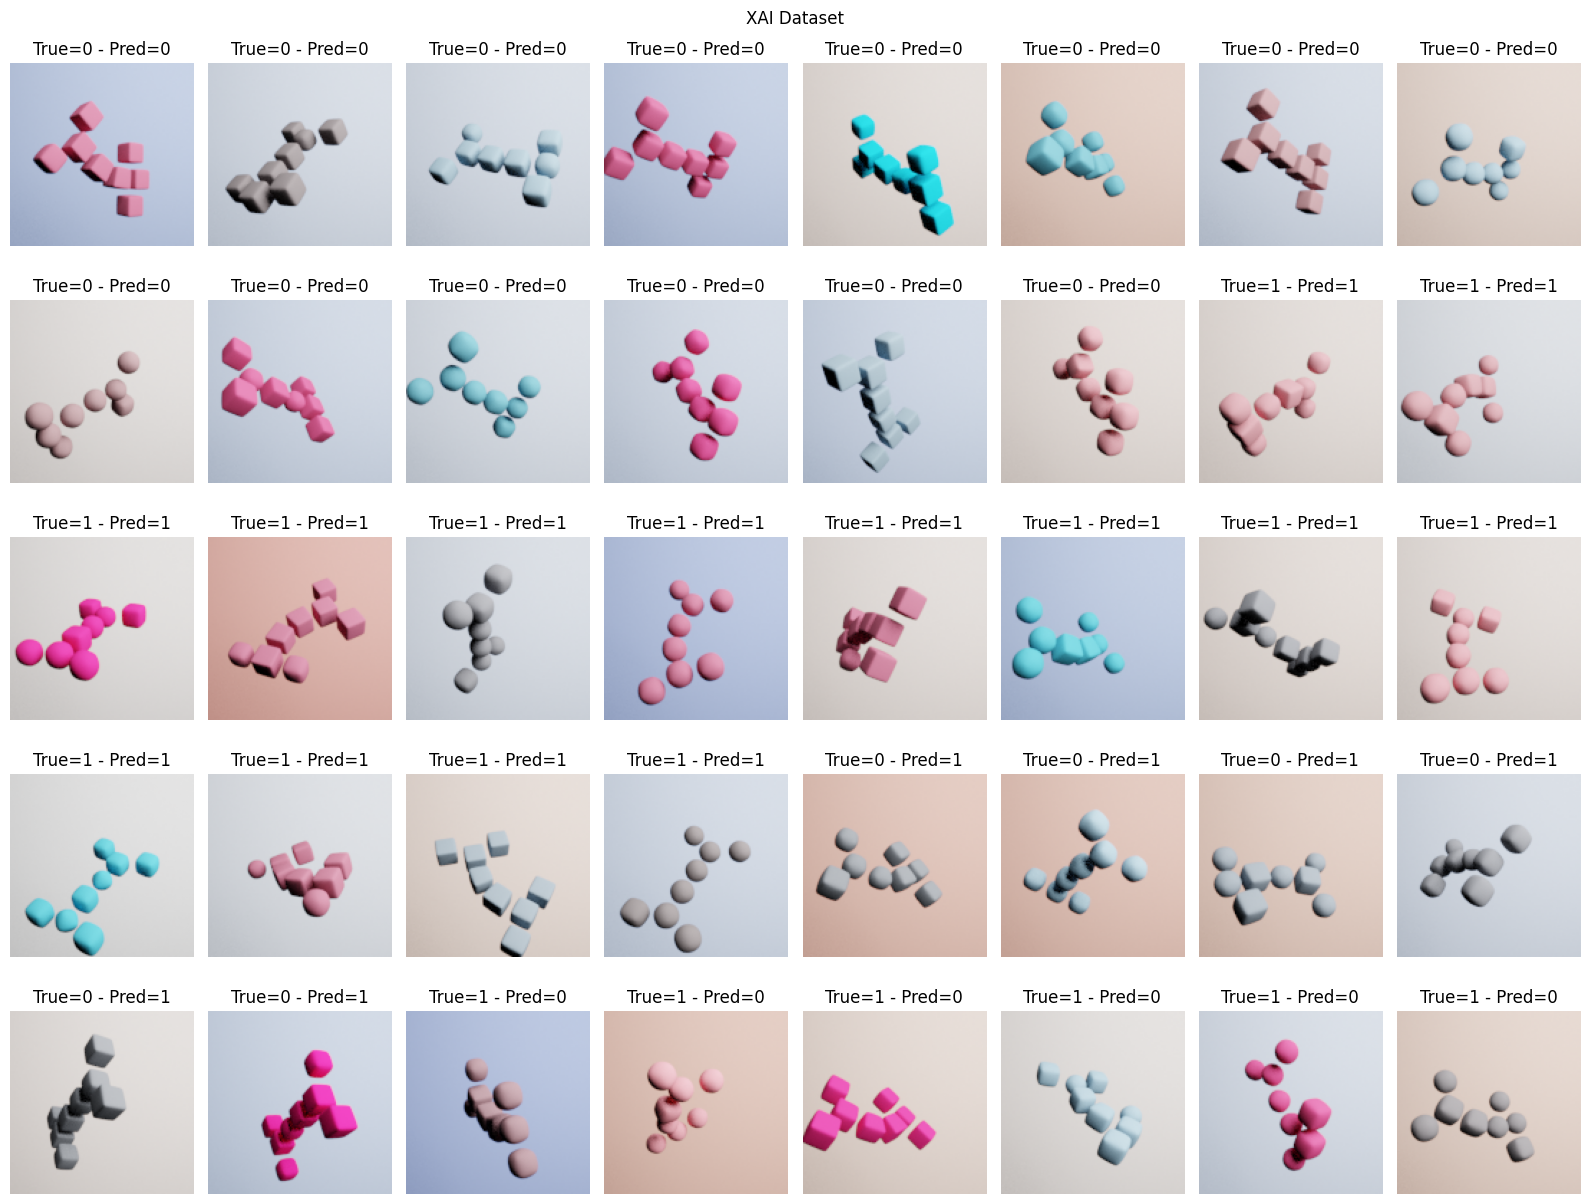

In [15]:
display_images(xai_df, 5, 8, eval_ds_dir / 'test', f'XAI Dataset', random_state=0)

## Generate Examples

In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from PIL import Image

def compute_feature_distances(target_features, dataset_features):
    """
    Compute distances between target features and all dataset examples.
    """
    distances = euclidean_distances(target_features.reshape(1, -1), dataset_features)
    return distances.flatten()

def get_closest_examples(target_features, dataset_df, feature_columns, N=5):
    """
    Find the closest N examples to the target features based on specified columns.
    """
    dataset_features = dataset_df[feature_columns].values
    distances = compute_feature_distances(target_features, dataset_features)
    dataset_df['distance'] = distances
    closest_examples = dataset_df.nsmallest(N, 'distance')
    return closest_examples

def visualize_examples_with_predictions(target_image_path, target_pred, target_true, closest_examples, data_dir, class_names):
    """
    Visualize the target image, the closest examples, and their predicted classes.
    
    Args:
        target_image_path (str): Path to the target image.
        closest_examples (DataFrame): DataFrame containing the closest examples.
        data_dir (Path): Directory containing the image data.
        model (torch.nn.Module): Trained model for prediction.
        transform (torchvision.transforms.Compose): Transformations to apply to images.
        device (torch.device): Device to use (CPU or GPU).
        class_names (list): List of class names corresponding to model outputs.
    """
    # Load the target image
    target_image = Image.open(target_image_path).convert('RGB')

    # Plot target image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(closest_examples) + 1, 1)
    plt.imshow(target_image)
    plt.title(f"Target Image\nPred: {class_names[target_pred]}\nActual: {class_names[target_true]}")
    plt.axis("off")

    # Predict and plot closest examples
    for idx, (_, row) in enumerate(closest_examples.iterrows()):  # Fix the index to be sequential
        example_image_path = data_dir / row['filename']
        example_image = Image.open(example_image_path).convert('RGB')
        pred = row['pred']
        true_label = int(row['ill'])
        predicted_class = class_names[pred]
        true_class = class_names[true_label]

        # Plot the image with prediction and distance
        plt.subplot(1, len(closest_examples) + 1, idx + 2)
        plt.imshow(example_image)
        plt.title(f"Dist: {row['distance']:.2f}\nPred: {predicted_class}\nTrue: {true_class}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


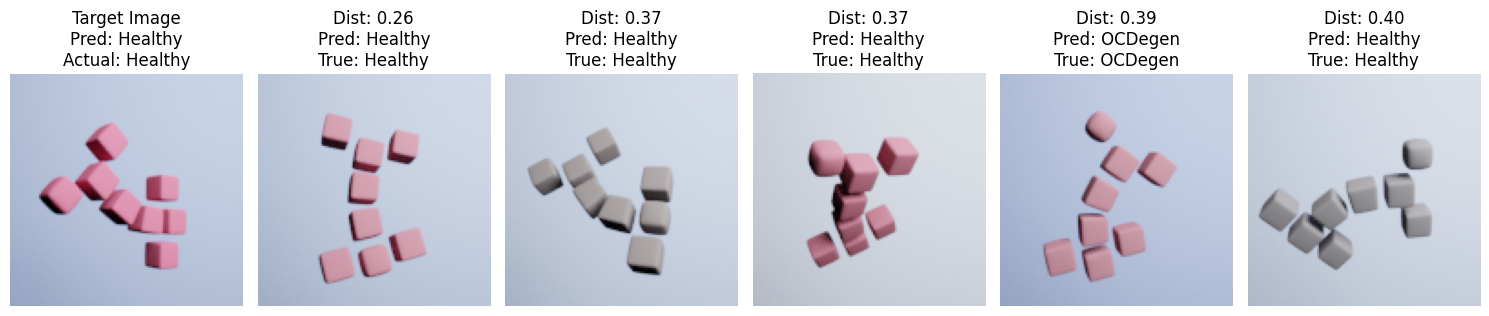

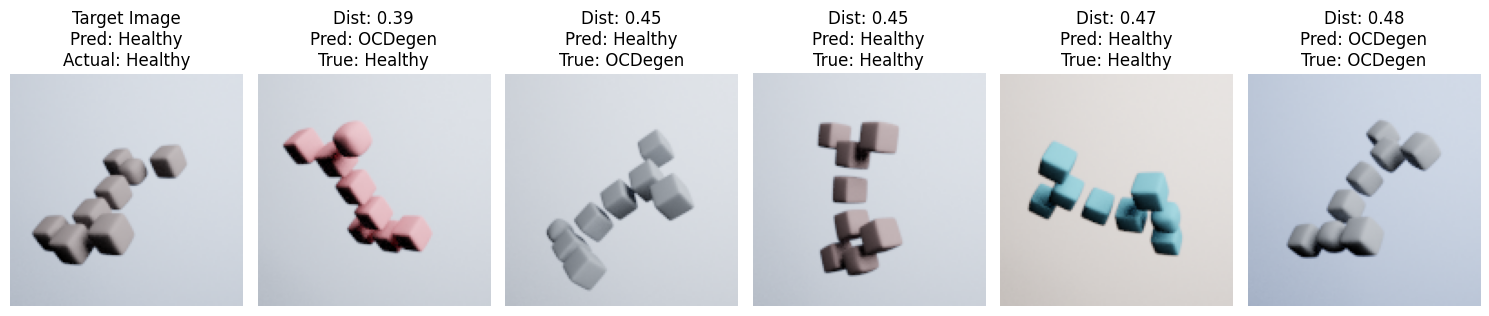

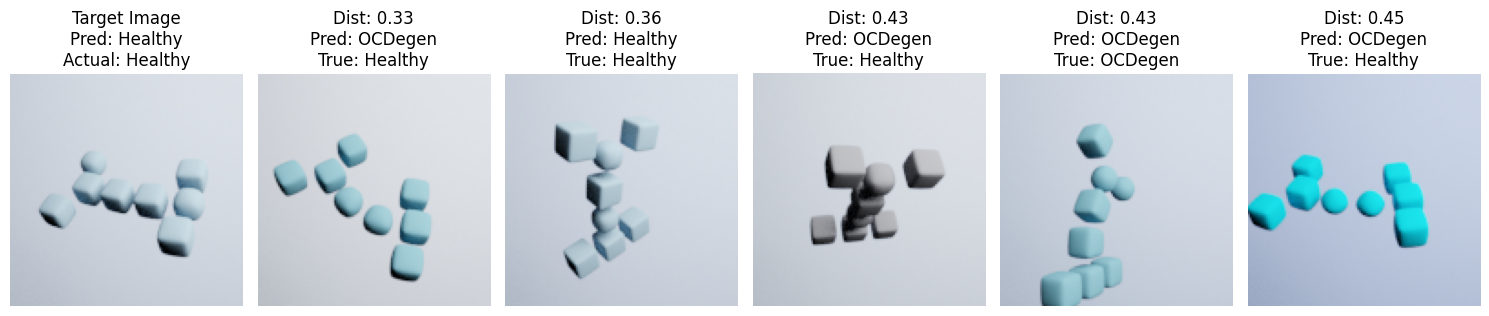

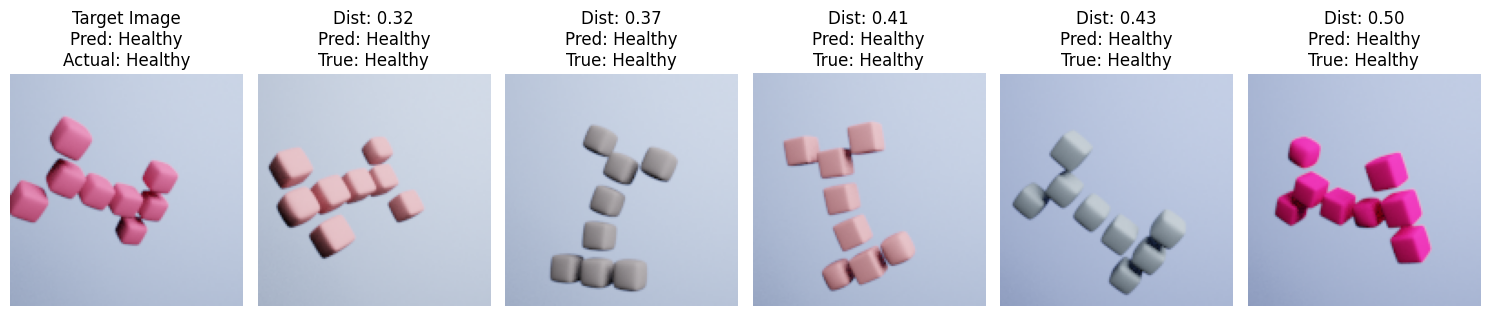

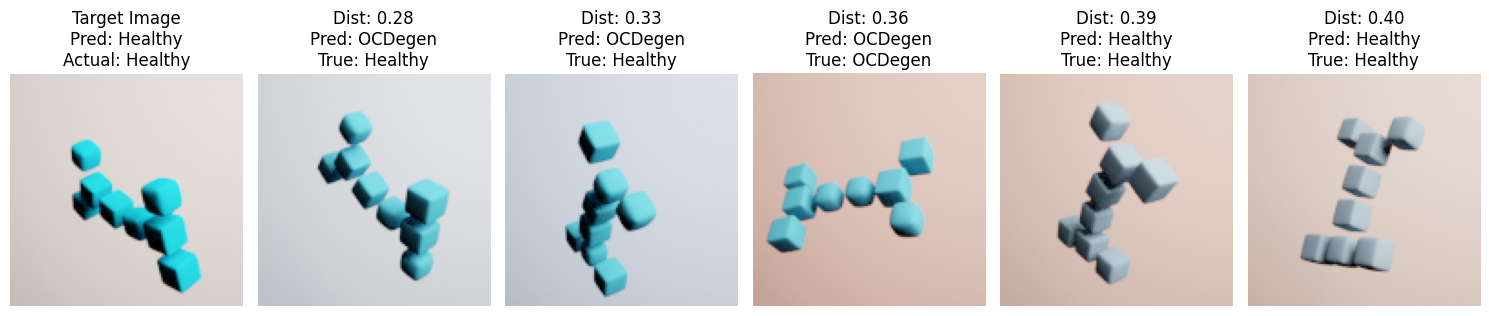

In [ ]:

# Specify feature columns
feature_columns = [
    'spherical', 'ill_spherical', 'num_diff', 'bending', 'obj_rotation_roll', 
    # 'obj_rotation_pitch', 'obj_rotation_yaw', 'fliplr', 
    # 'position_x', 'position_y', 
    'arm_position', 'obj_color', 'bg_color'
]

for idx, row in xai_df.sample(5).iterrows():

  # Example usage
  target_image_path = str(eval_ds_dir / 'test' / row['filename'])  # Path to target image
  target_features = row[feature_columns].values  # Features of target image
  target_pred = row['pred']  # Prediction of target image
  target_true = row['ill']  # True label of target image
  target_true = int(target_true)

  # Get closest examples
  N = 5  # Number of closest examples to retrieve
  id_to_drop = row['id']  # Extract the 'id' column from xai_df
  filtered_eval_df = eval_df.loc[eval_df['id'] != id_to_drop].copy()
  closest_examples = get_closest_examples(target_features, filtered_eval_df, feature_columns, N)

  # Visualize results
  # Example usage
  visualize_examples_with_predictions(
      target_image_path=target_image_path,
      target_pred=target_pred,
      target_true=target_true,
      closest_examples=closest_examples,
      data_dir=eval_ds_dir / 'test',
      class_names=CLASSES
  )